In [70]:

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/root/ProtAgent")
from agent.workflow.workflow_manager import WorkflowManager
from agent.tools.tool_manager import ToolManager


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Data Generation

In [71]:
tool_manager = ToolManager()


In [72]:
transfer_matrix = {}
for tool_name, obj in tool_manager.tools.items():
    if tool_name == "chat":
        continue
    doc = obj.config.document
    output_types = set([param["detailed_type"] for param in doc.return_values])
    
    transfer_matrix[tool_name] = []
    for another_tool, obj in tool_manager.tools.items():
        if tool_name == "chat":
            continue
        if another_tool == tool_name:
            continue
        another_doc = obj.config.document
        input_types = set([param["detailed_type"] for param in another_doc.required_parameters])
        # Check if there's an intersection between output types of one tool and input types of another
        if output_types.intersection(input_types):
            if tool_name not in transfer_matrix:
                transfer_matrix[tool_name] = []
            transfer_matrix[tool_name].append(another_tool)

In [73]:
len(transfer_matrix), len(tool_manager.tools)  # Number of tools and number of transfer relations

(65, 66)

In [74]:
category_dict = {}
for tool_name, obj in tool_manager.tools.items():
    if tool_name == "chat":
        continue
    doc = obj.config.document
    category = doc.category_name
    if category not in category_dict:
        category_dict[category] = []
    category_dict[category].append(tool_name)

In [75]:
category_dict.keys()

dict_keys(['Structure', 'Sequence', 'Function', 'Design', 'Knowledge', 'Multimodal'])

In [82]:
cutomization_dict = {
    "Mmseqs": "MMseqs2",
    "Interproscan": "InterProScan",
    "Deepab": "DeepAb",
    "Diffab": "DiffAb",
    "Alphafold2": "AlphaFold2",
    "Pubmed": "PubMed",
    "Clustalw": "ClustalW",
    "Blast": "BLAST",
    "Hhalign": "HHalign",
    "Hhblits": "HHblits",
    "Hhmake": "HHmake",
    "Hhfilter": "HHfilter",
    "Hhsearch": "HHsearch",
    "Hmmbuild": "HMMbuild",
    "Hmmscan": "HMMscan",
    "Pdb": "PDB",
    "Uniprot": "UniProt",
    "Tmalign": "TMalign",
    "Rfdiffusion": "RFDiffusion",
    "Proteinmpnn": "ProteinMPNN",
    "Esmfold": "ESMfold",
    "Pdb2aasequence": "PDB2aasequence",
    "Hmmsearch": "HMMsearch",
}

In [83]:
def label_customization(label):
    """
    Custom label function to format node labels.
    """
    main_func = None
    detailed_func = ""
    for word in label.split('_'):
        if not main_func:
            main_func = word.capitalize()
        else:
            detailed_func += word[0]
    
    if main_func in cutomization_dict:
        main_func = cutomization_dict[main_func]
    
    if len(detailed_func) > 0:
        return f"{main_func} ({detailed_func})"
    else:
        return main_func

#### Visualization

In [84]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np # We need numpy for position calculations

def draw_clustered_circular_layout(transfer_matrix, node_category_dict):
    """
    Draws a networkx graph using a circular layout with clustered nodes.
    This version is optimized for denser graphs, ensures a perfect circle aspect ratio,
    and allows for custom label formatting (e.g., showing only the first part of a name).

    Args:
        transfer_matrix (dict): Adjacency list for the graph.
        node_category_dict (dict): Dictionary mapping categories to nodes.
    """
    # --- 1. Create the Graph ---
    G = nx.DiGraph(transfer_matrix)
    all_nodes_in_categories = {node for nodes in node_category_dict.values() for node in nodes}
    G.add_nodes_from(all_nodes_in_categories)
    print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    # --- 2. Sort Nodes by Category for Layout ---
    sorted_categories = sorted(node_category_dict.keys())
    sorted_nodes = []
    for category in sorted_categories:
        nodes_in_category = sorted(node_category_dict[category])
        sorted_nodes.extend(nodes_in_category)
    
    # --- 3. Generate Colors based on Category ---
    node_to_category = {
        node: category 
        for category, nodes in node_category_dict.items() 
        for node in nodes
    }
    num_categories = len(sorted_categories)
    colormap = ["#155289", "#584482", "#883268", "#AA7A38", "#335A30", "#3E7274"] 
    category_color_map = {
        category: colormap[i] 
        for i, category in enumerate(sorted_categories)
    }
    node_colors = [category_color_map[node_to_category.get(node, 'default')] for node in sorted_nodes]

    # --- 4. Calculate Layout and Label Positions ---
    pos = nx.circular_layout(sorted_nodes)
    
    label_offset = 0.05
    label_pos = {
        node: ( (1 + label_offset) * x, (1 + label_offset) * y )
        for node, (x, y) in pos.items()
    }

    # --- 5. Create Custom Labels (NEW) ---
    # Create a dictionary for labels where 'NodeName_ExtraInfo' becomes 'NodeName'
    custom_labels = {node: label_customization(node) for node in G.nodes()}
    print("Custom labels generated. Example:", list(custom_labels.items())[0])

    # --- 6. Draw the Graph ---
    plt.figure(figsize=(18, 18))
    ax = plt.gca()

    # A. Draw the edges first, with transparency
    nx.draw_networkx_edges(
        G,
        pos,
        edge_color='#AAAAAA',
        width=0.7,
        alpha=0.5,
        arrows=True,
        arrowstyle='-|>',
        arrowsize=12,
        connectionstyle='arc3,rad=0.05'
    )

    # B. Draw the nodes on top of the edges
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=sorted_nodes,
        node_size=600,
        node_color=node_colors
    )

    # C. Draw the custom labels at their offset positions (MODIFIED)
    nx.draw_networkx_labels(
        G,
        label_pos,
        labels=custom_labels, # Use the custom labels dictionary
        font_size=8, # Slightly increased font size, adjust as needed
        font_weight='bold',
        font_color='black'
    )

    # # D. Create the legend
    # legend_handles = [
    #     plt.Rectangle((0, 0), 1, 1, color=color) 
    #     for color in category_color_map.values()
    # ]
    # plt.legend(
    #     legend_handles, 
    #     category_color_map.keys(), 
    #     title="Categories", 
    #     bbox_to_anchor=(1.02, 1), 
    #     loc='upper left',
    #     fontsize='large',
    #     title_fontsize='x-large'
    # )
    
    # E. Final plot adjustments
    # plt.title(f"Clustered Circular Layout ({G.number_of_nodes()} Nodes, {G.number_of_edges()} Edges)", size=20)
    
    # Ensure the plot is a perfect circle (NEW)
    ax.set_aspect('equal')
    
    # Remove the black box around the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # plt.tight_layout()
    # plt.show()
    plt.savefig("clustered_circular_layout.svg", bbox_inches='tight', dpi=300, transparent=True)



Graph created with 65 nodes and 512 edges.
Custom labels generated. Example: ('alphafold2', 'AlphaFold2')


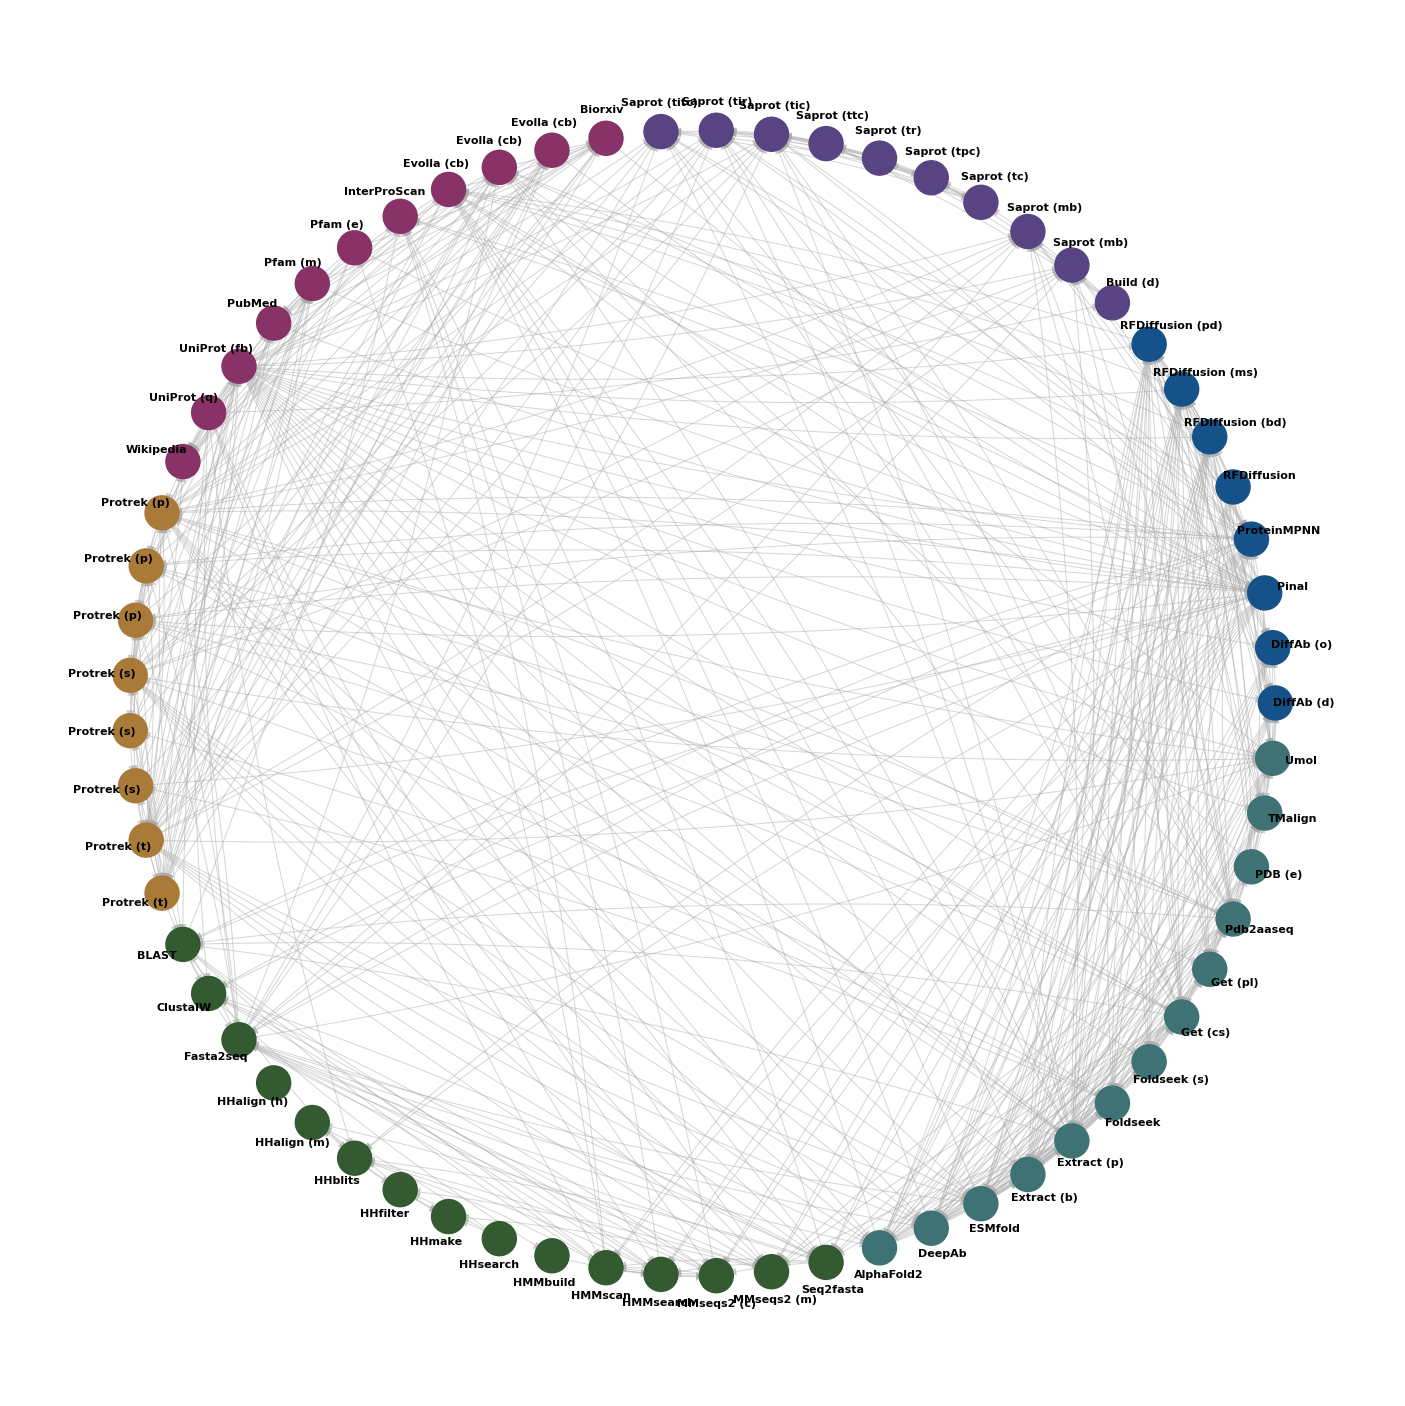

In [85]:
draw_clustered_circular_layout(transfer_matrix, category_dict)

In [86]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def draw_adjacency_heatmap(transfer_matrix, node_category_dict):
    """
    Draws a heatmap of the adjacency matrix.

    The rows and columns are ordered by node category to align with the
    circular plot visualization. Blue cells indicate a connection (1),
    and white cells indicate no connection (0).

    Args:
        transfer_matrix (dict): Adjacency list for the graph.
        node_category_dict (dict): Dictionary mapping categories to nodes.
    """
    # --- 1. Get a consistently sorted list of all nodes ---
    # This logic MUST match the circular plot function to ensure consistency.
    all_nodes_in_categories = {node for nodes in node_category_dict.values() for node in nodes}
    # Also consider nodes that might only be in the transfer_matrix keys (sources)
    all_graph_nodes = all_nodes_in_categories.union(set(transfer_matrix.keys()))

    sorted_categories = sorted(node_category_dict.keys())
    sorted_nodes = []
    for category in sorted_categories:
        # Get nodes for this category and sort them alphabetically
        nodes_in_category = sorted([n for n in node_category_dict[category] if n in all_graph_nodes])
        sorted_nodes.extend(nodes_in_category)
    
    # Add any remaining nodes not in any category, also sorted
    nodes_not_in_categories = sorted(list(all_graph_nodes - set(sorted_nodes)))
    sorted_nodes.extend(nodes_not_in_categories)
    
    num_nodes = len(sorted_nodes)
    print(f"Heatmap will be generated for {num_nodes} ordered nodes.")

    # Create a mapping from node name to its index in the sorted list
    node_to_index = {node: i for i, node in enumerate(sorted_nodes)}

    # --- 2. Build the N x N adjacency matrix ---
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

    for source_node, target_nodes in transfer_matrix.items():
        if source_node not in node_to_index:
            continue # Skip if source node is not in our defined categories
        for target_node in target_nodes:
            if target_node not in node_to_index:
                continue # Skip if target node is not in our defined categories
            
            source_idx = node_to_index[source_node]
            target_idx = node_to_index[target_node]
            adjacency_matrix[source_idx, target_idx] = 1

    # --- 3. Prepare for Plotting ---
    # Use the same short label format as the circular plot
    short_labels = [label_customization(node) for node in sorted_nodes]
    
    # Create a pandas DataFrame for easier plotting with Seaborn
    adjacency_df = pd.DataFrame(adjacency_matrix, index=short_labels, columns=short_labels)

    # Create a custom colormap: 0 -> white, 1 -> blue
    custom_cmap = ListedColormap(['white', 'royalblue'])

    # --- 4. Draw the Heatmap ---
    plt.figure(figsize=(14, 12))
    ax = sns.heatmap(
        adjacency_df,
        cmap=custom_cmap,
        linewidths=0.5,         # Add lines between cells
        linecolor='lightgray',
        cbar=False,             # The color bar is not needed for a binary map
        square=True             # Ensure cells are square
    )

    # --- 5. Final Plot Adjustments ---
    # plt.title('Adjacency Matrix Heatmap', fontsize=20, pad=20)
    # ax.set_xlabel('Target Node', fontsize=14, labelpad=15)
    # ax.set_ylabel('Source Node', fontsize=14, labelpad=15)
    
    # Improve tick label readability
    ax.tick_params(axis='x', labelrotation=90)
    ax.tick_params(axis='y', labelrotation=0)
    
    # Set background transparent
    
    
    
    plt.savefig("adjacency_heatmap.svg", bbox_inches='tight', dpi=300, transparent=True)
    plt.tight_layout()
    plt.show()


Heatmap will be generated for 65 ordered nodes.


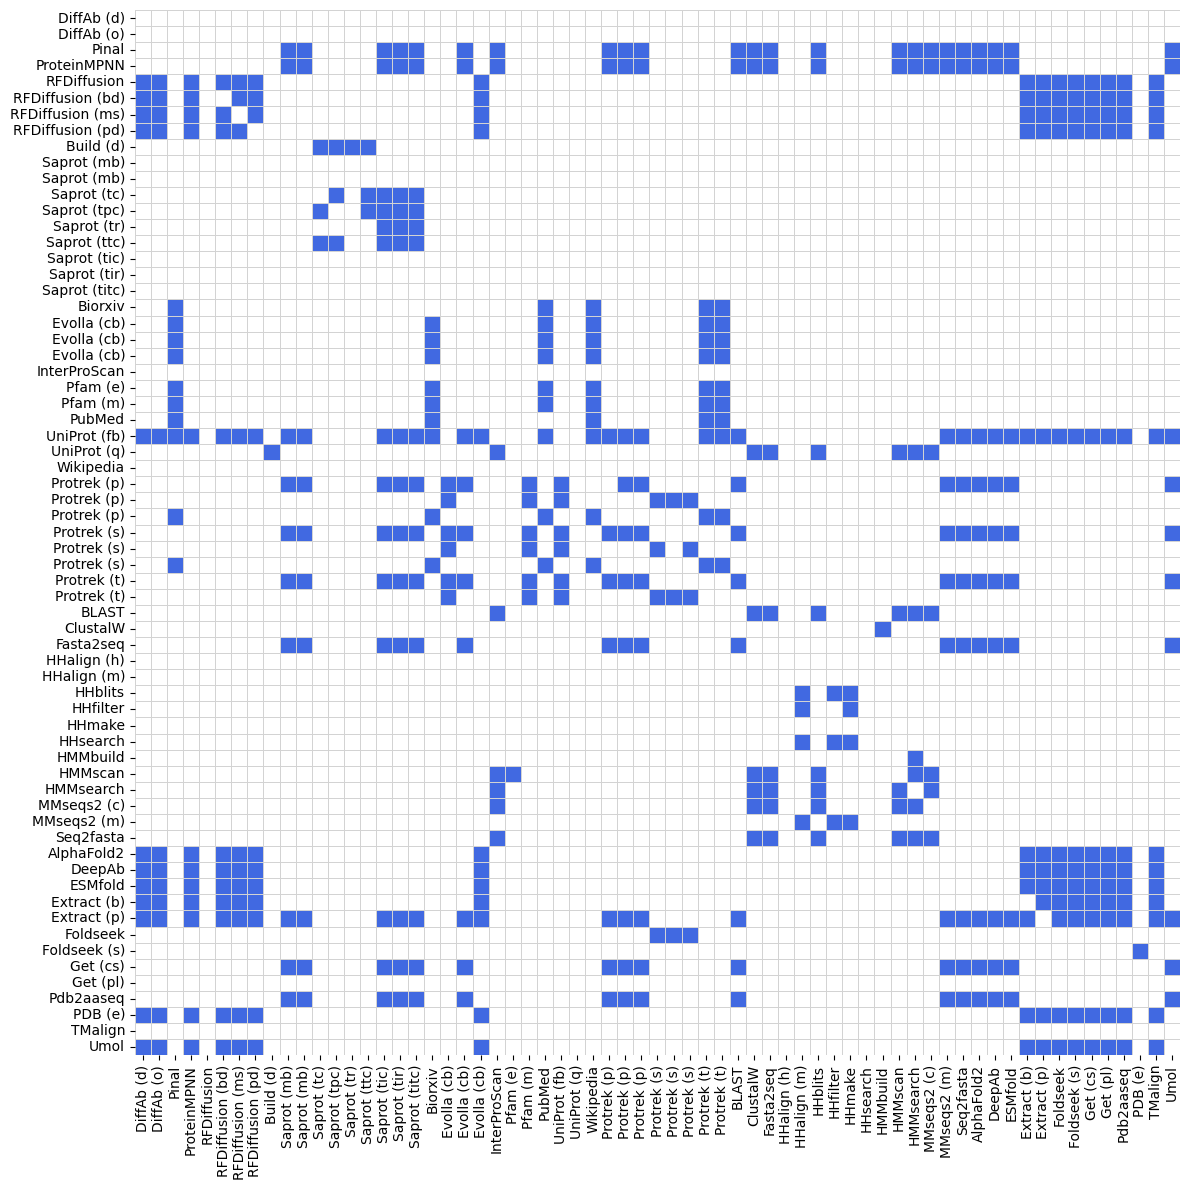

In [87]:
draw_adjacency_heatmap(transfer_matrix, category_dict)